In [1]:
!unzip -qq /content/hymenoptera_data.zip

replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Step 01. 모델 설계

### 1.1 라이브러리 불러오기

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

### 1.2 데이터 불러오기

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train' : transforms.Compose([
                                  transforms.RandomResizedCrop(224),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val' : transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [4]:
# Google Colab에서 사용하여 아래와 같은 경로로 저장하였습니다.
# 개인의 경로에 맞게 아래의 경로를 수정하시기 바랍니다.
data_dir = '/content/hymenoptera_data'
image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x),
                                           data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x : torch.utils.data.DataLoader(image_datasets[x], batch_size = 4,
                                               shuffle = True, num_workers = 2)
              for x in ['train', 'val']}

dataset_sizes = {x : len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: /content/hymenoptera_data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: /content/hymenoptera_data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [6]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fdd0e30ee10>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fdd6bb81e50>}

In [7]:
print("class_names : ", class_names)
print("\n")
print("datasets_sizes : ", dataset_sizes)
print("\n")
print("image_datasets : ", image_datasets)

class_names :  ['ants', 'bees']


datasets_sizes :  {'train': 244, 'val': 153}


image_datasets :  {'train': Dataset ImageFolder
    Number of datapoints: 244
    Root location: /content/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 153
    Root location: /content/hymenoptera_data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}


### 1.3 샘플 이미지 시각화

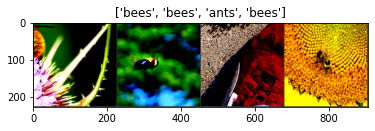

In [8]:
def imshow(inp, title = None) :
  # Imshow for Tensor
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std + inp * mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  
  if title is not None :
    plt.title(title)

# pause a bit so that plots are plotted
plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title = [class_names[x] for x in classes])

In [9]:
print("inputs : ", inputs)
print("\n")
print("out : ", out)

inputs :  tensor([[[[-0.8164, -0.7308, -0.7650,  ..., -1.1760, -1.1932, -1.1760],
          [-0.8507, -0.8678, -0.8678,  ..., -1.1760, -1.1932, -1.1932],
          [-0.7822, -0.7822, -0.7650,  ..., -1.1932, -1.2103, -1.2103],
          ...,
          [ 2.1804,  2.1633,  2.2147,  ..., -1.2103, -1.1418, -1.0904],
          [ 2.1975,  2.2147,  2.2147,  ..., -1.1418, -1.0904, -1.0733],
          [ 2.0263,  2.0777,  2.0948,  ..., -1.1075, -1.0562, -1.0390]],

         [[-0.0224,  0.0301, -0.0049,  ..., -0.7577, -0.7402, -0.7227],
          [ 0.0126, -0.0049,  0.0301,  ..., -0.7577, -0.7402, -0.7402],
          [ 0.0126,  0.0301,  0.0476,  ..., -0.7752, -0.7577, -0.7402],
          ...,
          [ 1.9384,  1.9909,  2.0959,  ..., -0.2325, -0.1625, -0.1275],
          [ 2.1134,  2.1485,  2.1310,  ..., -0.2150, -0.1275, -0.0924],
          [ 1.6583,  1.6933,  1.7283,  ..., -0.1800, -0.1099, -0.0574]],

         [[-1.8044, -1.7347, -1.7696,  ..., -1.7870, -1.7696, -1.7522],
          [-1.8044, 

## Step 02. 모델 및 시각화 함수 정의

### 2.1 모델 학습하기
* Scheduling the learning rate
* Saving the best model

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25)  :
  since = time.time()

# 모델 가중치(weights) 불러오기
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs)  :
    print("Epoch {}/{}".format(epoch, num_epochs - 1))
    print("-" * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val'] :
      if phase == 'train' :
        model.train()   # Set model to training mode

      else :
        model.eval()    # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase] :
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train') :
          outputs = model(inputs)
          # print("outputs : ", outputs)
          # print("\n")
          # print("torch.max(outputs, 1) : ", torch.max(outputs, 1))
          # print("\n")
          _, preds = torch.max(outputs, 1)
          # print("\n")
          # print("_, preds : ", _, preds)
          # print("\n")
          # print("preds : ", preds)
          # print("\n")
          loss = criterion(outputs, labels)
          
          # backward + optimize only if in training phase
          if phase == 'train' :
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      
      if phase == 'train' :
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print("{} Loss : {:.4f} Acc : {:.4f}".format(
        phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc :
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print("Training complete in {:.0f}m {:.0f}s".format(
      time_elapsed // 60, time_elapsed % 60))
  print("Best val Acc : {:4f}".format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

### 2.2 예측한 모델 시각화하기

In [11]:
def visualize_model(model, num_images = 6) :
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad() :
    for i, (inputs, labels) in enumerate(dataloaders['val']) :
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]) :
        images_so_far += 1
        ax = plt.subplot(num_images // 2, 2, images_so_far)
        ax.axis("off")
        ax.set_title("predicted : {}".format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images :
          model.train(mode = was_training)
          return
    model.train(mode = was_training)

### 2.3 Finetuning the convnet

In [12]:
model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

# resnet18 모델을 가져와 기존의 feature를, nn.Linear를 사용하여 2개의 feature(ants, bees)를 분류할 수 있게 변경.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

# 손실함수 정의
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

## Step 03. 모델 학습 및 평가

In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss : 0.5040 Acc : 0.7377
val Loss : 0.3973 Acc : 0.8693

Epoch 1/24
----------
train Loss : 0.4806 Acc : 0.8484
val Loss : 0.3875 Acc : 0.8366

Epoch 2/24
----------
train Loss : 0.5357 Acc : 0.7705
val Loss : 0.4966 Acc : 0.8105

Epoch 3/24
----------
train Loss : 0.4906 Acc : 0.8156
val Loss : 0.2785 Acc : 0.8889

Epoch 4/24
----------
train Loss : 0.6502 Acc : 0.7828
val Loss : 0.4601 Acc : 0.8562

Epoch 5/24
----------
train Loss : 0.6059 Acc : 0.7623
val Loss : 0.3388 Acc : 0.8889

Epoch 6/24
----------
train Loss : 0.5388 Acc : 0.8033
val Loss : 0.3710 Acc : 0.8497

Epoch 7/24
----------
train Loss : 0.4714 Acc : 0.7541
val Loss : 0.2861 Acc : 0.8889

Epoch 8/24
----------
train Loss : 0.3300 Acc : 0.8320
val Loss : 0.2880 Acc : 0.9085

Epoch 9/24
----------
train Loss : 0.3075 Acc : 0.8730
val Loss : 0.2504 Acc : 0.8954

Epoch 10/24
----------
train Loss : 0.3358 Acc : 0.8484
val Loss : 0.2376 Acc : 0.9020

Epoch 11/24
----------
train Loss : 0.3232 Acc : 0.8320
val Loss

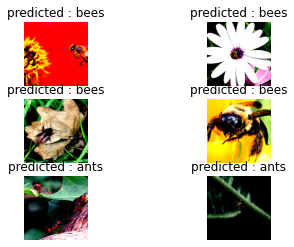

In [14]:
visualize_model(model_ft)

## Step 04. FC layer를 제외한 나머지 parameter 동결

Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

### 4.1 모델 학습 및 평가(동결된 모델)

In [15]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss : 0.5879 Acc : 0.7049
val Loss : 0.3701 Acc : 0.8366

Epoch 1/24
----------
train Loss : 0.5626 Acc : 0.7131
val Loss : 0.2810 Acc : 0.9085

Epoch 2/24
----------
train Loss : 0.5619 Acc : 0.7541
val Loss : 0.2008 Acc : 0.9346

Epoch 3/24
----------
train Loss : 0.4619 Acc : 0.8033
val Loss : 0.2763 Acc : 0.8889

Epoch 4/24
----------
train Loss : 0.4305 Acc : 0.8156
val Loss : 0.2276 Acc : 0.9216

Epoch 5/24
----------
train Loss : 0.3348 Acc : 0.8525
val Loss : 0.2023 Acc : 0.9346

Epoch 6/24
----------
train Loss : 0.5464 Acc : 0.7705
val Loss : 0.1932 Acc : 0.9346

Epoch 7/24
----------
train Loss : 0.4074 Acc : 0.8238
val Loss : 0.1876 Acc : 0.9412

Epoch 8/24
----------
train Loss : 0.4289 Acc : 0.8115
val Loss : 0.1892 Acc : 0.9412

Epoch 9/24
----------
train Loss : 0.3380 Acc : 0.8607
val Loss : 0.1670 Acc : 0.9542

Epoch 10/24
----------
train Loss : 0.3453 Acc : 0.8525
val Loss : 0.1764 Acc : 0.9542

Epoch 11/24
----------
train Loss : 0.3124

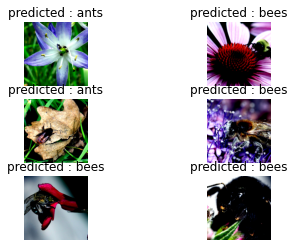

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()